In [1]:
#необходимые пакеты 
import ee, geemap, os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as gpd 
import scipy

In [2]:
#geemap.update_package()


In [3]:
ee.Initialize()

### Границы региона 

In [4]:
region_boundary = geemap.geojson_to_ee('data/budenovsk_district_boundaries.geojson')

Budenovsk = geemap.Map(zoom = 10)

Budenovsk.centerObject(region_boundary)

Budenovsk.addLayer(region_boundary ,{'color' : "FF0000"}, 'Границы региона' )

Budenovsk

Map(center=[44.745544055004785, 44.14114333519604], controls=(WidgetControl(options=['position'], widget=HBox(…

### подготовка коллекции для дальнейшей обработки

In [5]:
# возьмем коллекцию сентинел и обработаем ее немного
def masking(img) : 
    cloudProb = img.select('MSK_CLDPRB')  # покрытие облаками
    snowProb = img.select('MSK_SNWPRB') # покрытие снегом
    cloud = cloudProb.lt(1) # создали бинарную маску иными словами просто все что имеет значение меньше 5 одна группа выше другая
                            # а мы помним что пиксели принимают значения от 0 до 255
    snow = snowProb.lt(1) # тоже самое что с облаками
    scl = img.select('SCL') # слой с классификатором(есть в sentinel 2 уровня обработки 2А)
    shadow = scl.neq(3);# 3 в классификации это тени от облаков
    cirrus_medium = scl.neq(8) # тоже по классификации облака 
    cirrus_high = scl.neq(9) # аналогично облака
    cirrus = scl.neq(10); # 10 это перистые облака или цирусы
    masked_img = img.updateMask(cloud).updateMask(shadow).updateMask(cirrus).updateMask(cirrus_medium).updateMask(cirrus_high)
    return(masked_img)

def clipper_region(image):
    clipped = image.clip(region_boundary.geometry())
    return  clipped 

#создали коллекцию с изображениями
start = ee.Date('2018-09-01')
finish = ee.Date('2019-09-01')
sentinel2_collection = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(region_boundary.geometry()) \
    .filterMetadata("CLOUD_COVERAGE_ASSESSMENT", 'less_than', 20.0) \
    .filterMetadata('SNOW_ICE_PERCENTAGE','less_than', 5.0) \
    .filterDate(start, finish)  \
    .map(masking).map(clipper_region)
sentinel2_collection_list = sentinel2_collection.toList(sentinel2_collection.size().getInfo())

#вынимаем уникальные даты из датасета
sentinel2_collection_list = sentinel2_collection.toList(sentinel2_collection.size().getInfo())
sentinel2_time_list = []
for i in range(sentinel2_collection.size().getInfo()):
    img = ee.Image(sentinel2_collection_list.get(i))
    time = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd').getInfo()
    sentinel2_time_list.append(time)

#уникальные даты из датасета
unique_dates = sorted(list(set(sentinel2_time_list)))

diff = finish.difference(start , 'day')
Range = ee.List.sequence(0, diff.subtract(1)).map(lambda day :  start.advance(day,'day'))
def day_mosaics(date , newlist):
    date = ee.Date(date)
    newlist = ee.List(newlist)
    
    filtered = sentinel2_collection.filterDate(date , date.advance(1,'day'))
    
    image = ee.Image(filtered.mosaic())
    
    return ee.List(ee.Algorithms.If(filtered.size(), newlist.add(image), newlist))
sentinel2_collection_mosaic = ee.ImageCollection(ee.List(Range.iterate(day_mosaics, ee.List([]))))

In [6]:
#визуал для сентинел 2 
visualization = {"min": 0.0, "max": 2000,"bands": ['B4', 'B3', 'B2']}

In [7]:
def sentinel2_NDTI(image):
    NDTI = image.normalizedDifference(['B11', 'B12']).rename('NDTI')
    return image.addBands([NDTI])

MiniNDTI = sentinel2_collection_mosaic.map(sentinel2_NDTI).select('NDTI').min().rename('minNDTI').reproject(crs= 'EPSG:32638' , crsTransform = [60, 0, 300000, 0, -60, 5000040])





In [8]:
Budenovsk.addLayer(MiniNDTI, {'min' : 0 , 'max' : 0.2, 'palette' :['FFFF00','FFF000','FF0000' ]}, "minNDTI") # добавили на карту

In [52]:
Archangelskoe = gpd.read_file('data/archangelskoe_wgs84.geojson' )
Praskoveya = gpd.read_file('Data/praskoveya_wgs84.geojson')

Archangelskoe['type'] = 'PP'
Praskoveya['type'] = 'TT'

fields = Praskoveya.append(Archangelskoe)[['type','geometry']]
fields['number'] = [i for i in range(0,fields.shape[0])]
fields_ee = geemap.geopandas_to_ee(fields)




In [10]:
Budenovsk.add_styled_vector(fields_ee, column = 'type',palette = ['00FF2A',"FF8001" ], layer_name = 'разные технологии обработки') 


In [58]:

#minNDTI_DF = MiniNDTI.select('minNDTI').sampleRegions(fields_ee)
#geemap.ee_export_vector(minNDTI_DF, filename='C:/Users/User/Google Диск/python_notebooks/Archangelskoe_NDTI_project/Data/minNDTI.csv')



Generating URL ...
Please wait ...
Data downloaded to C:\Users\User\Google Диск\python_notebooks\Archangelskoe_NDTI_project\Data\minNDTI.csv


In [61]:
minNDTI_pd_df = pd.read_csv('Data/minNDTI.csv')
minNDTI_pd_df

minNDTI_pd_df[['field_№', 'number']] = minNDTI_pd_df['system:index'].str.split('_', 1, expand=True)
minNDTI_pd_df = minNDTI_pd_df.drop(["system:index",'number' ], 1)

minNDTI_pd_df

,type,minNDTI,field_№
0,TT,0.022935,0
1,TT,0.044681,0
2,TT,0.043812,0
3,TT,0.003171,0
4,TT,-0.001263,0
...,...,...,...
81909,PP,0.037835,269
81910,PP,0.038556,269
81911,PP,0.045058,269
81912,PP,0.032397,269


minNDTI                      \
     count_nonzero      mean    median   
type                                     
PP         39013.0  0.041661  0.036770   
TT         42731.0  0.011008  0.008413   

                                               
                        kholmogorov_norm_test  
type                                           
PP    распределение отличается от нормального  
TT    распределение отличается от нормального

выборки различаются при p уровне значимости 0.0


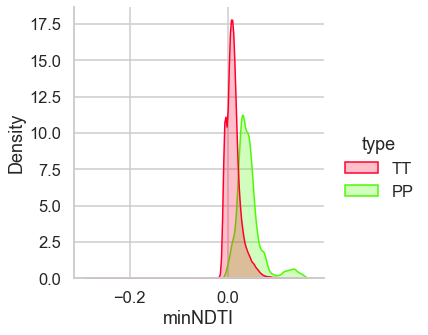

In [98]:
# проверка на нормальность тестом холмогорова 

#sns.set_style("whitegrid") 

sns.set_palette("prism_r")


def kholmogorov_norm_test(x):
    if scipy.stats.kstest(x, 'norm')[1] < 0.05:
        return('распределение отличается от нормального')
    else:
        return('распределение нормальное')
NDTI_sevoob_stats = minNDTI_pd_df[['type', 'minNDTI']].groupby(['type'] ).aggregate([np.count_nonzero, np.mean, np.median, kholmogorov_norm_test])

display(NDTI_sevoob_stats)

dentisty = sns.displot(minNDTI_pd_df, x='minNDTI',
                       hue="type", 
                       kind="kde", 
                       fill=True)

x = minNDTI_pd_df[minNDTI_pd_df.type == 'TT']["minNDTI"]
y = minNDTI_pd_df[minNDTI_pd_df.type != 'TT']["minNDTI"]
if scipy.stats.kruskal(x,y)[1] < 0.05:
    res = 'выборки различаются'
else:
    res = 'выборки не различаются'
print(f'{res} при p уровне значимости {scipy.stats.kruskal(x,y)[1]}')    
    

#### Короткое резюме 
все отлично получилось , различия между выборками есть
1) нужно посмотреть другие годы , и покрасивее сделать графику 
2) переходить к анализу по культурам (нужно будет делать кластерный анализ по группам 